In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits import mplot3d
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors

##### 导入一月份数据

In [2]:
trip = pd.read_parquet('nyc tlc/fhvhv_tripdata_2021-01.parquet')
trip

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02682,B02682,2021-01-01 00:28:09,2021-01-01 00:31:42,2021-01-01 00:33:44,2021-01-01 00:49:07,230,166,5.26,...,1.98,2.75,NaN,0.00,14.99,N,N,,N,N
1,HV0003,B02682,B02682,2021-01-01 00:45:56,2021-01-01 00:55:19,2021-01-01 00:55:19,2021-01-01 01:18:21,152,167,3.65,...,1.63,0.00,NaN,0.00,17.06,N,N,,N,N
2,HV0003,B02764,B02764,2021-01-01 00:21:15,2021-01-01 00:22:41,2021-01-01 00:23:56,2021-01-01 00:38:05,233,142,3.51,...,1.25,2.75,NaN,0.94,12.98,N,N,,N,N
3,HV0003,B02764,B02764,2021-01-01 00:39:12,2021-01-01 00:42:37,2021-01-01 00:42:51,2021-01-01 00:45:50,142,143,0.74,...,0.70,2.75,NaN,0.00,7.41,N,N,,N,N
4,HV0003,B02764,B02764,2021-01-01 00:46:11,2021-01-01 00:47:17,2021-01-01 00:48:14,2021-01-01 01:08:42,143,78,9.20,...,2.41,2.75,NaN,0.00,22.44,N,N,,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11908463,HV0003,B02765,B02765,2021-01-31 23:13:51,2021-01-31 23:25:03,2021-01-31 23:25:40,2021-01-31 23:40:10,89,71,2.29,...,1.49,0.00,NaN,0.00,12.06,N,N,,N,N
11908464,HV0003,B02872,B02872,2021-01-31 23:23:56,2021-01-31 23:29:03,2021-01-31 23:29:31,2021-01-31 23:47:44,182,167,4.10,...,1.53,0.00,NaN,2.00,13.66,N,N,,N,N
11908465,HV0003,B02872,B02872,2021-01-31 23:42:53,2021-01-31 23:49:23,2021-01-31 23:49:32,2021-02-01 00:04:36,167,169,2.40,...,1.73,0.00,NaN,0.00,15.53,N,N,,N,N
11908466,HV0003,B02764,B02764,2021-01-31 23:04:32,2021-01-31 23:09:13,2021-01-31 23:09:29,2021-01-31 23:27:46,188,37,3.60,...,1.76,0.00,NaN,0.00,17.36,N,N,,N,N


##### 选择起落点，起步价，是否要求共享和订单时间这几个属性来进行clustering

In [3]:
# trip_info = trip[['PULocationID', 'DOLocationID', 'base_passenger_fare', 
#                   'tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 
#                   'airport_fee', 'tips', 'driver_pay', 'shared_request_flag']]
trip_info = trip[['PULocationID', 'DOLocationID', 'base_passenger_fare', 
                  'shared_request_flag']]
trip_info = trip_info.replace({'shared_request_flag': {'N': 0, 'Y': 1}})
#trip_info['airport_fee'] = trip_info['airport_fee'].fillna(0)
trip_info['base_passenger_fare'] = trip_info['base_passenger_fare'].fillna(0)
#trip_info['PU_day'] = pd.DatetimeIndex(trip['pickup_datetime']).day
trip_info['PU_hour'] = pd.DatetimeIndex(trip['pickup_datetime']).hour
trip_info = trip_info[trip_info['base_passenger_fare'] > 0]

#### K-Means

##### 利用K-Means算法来进行初始分析, 分成三份

In [4]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(trip_info)
labels = kmeans.labels_

##### Cluster 0

In [5]:
pos_0 = np.argwhere(labels == 0).squeeze()
cluster_0 = trip_info.iloc[pos_0]
cluster_0_gp = cluster_0.groupby(['PULocationID', 'DOLocationID']) \
['base_passenger_fare'].mean().reset_index()

cluster_0_gp

,PULocationID,DOLocationID,base_passenger_fare
0,1,220,73.950000
1,1,221,63.950000
2,1,224,58.626667
3,1,225,75.450000
4,1,227,73.950000
...,...,...,...
20991,265,254,9.938462
20992,265,258,31.990000
20993,265,259,7.979500
20994,265,263,42.500000


##### Cluster 1

In [6]:
pos_1 = np.argwhere(labels == 1).squeeze()
cluster_1 = trip_info.iloc[pos_1]
cluster_1_gp = cluster_1.groupby(['PULocationID', 'DOLocationID']) \
['base_passenger_fare'].mean().reset_index()

cluster_1_gp

,PULocationID,DOLocationID,base_passenger_fare
0,1,1,59.656667
1,1,4,56.616667
2,1,7,75.950000
3,1,13,46.902222
4,1,14,70.450000
...,...,...,...
18642,135,39,27.234231
18643,135,41,26.321667
18644,135,42,26.037273
18645,135,43,17.950000


##### Cluster 2

In [7]:
pos_2 = np.argwhere(labels == 2).squeeze()
cluster_2 = trip_info.iloc[pos_2]
cluster_2_gp = cluster_2.groupby(['PULocationID', 'DOLocationID']) \
['base_passenger_fare'].mean().reset_index()

cluster_2_gp

,PULocationID,DOLocationID,base_passenger_fare
0,133,133,114.140000
1,134,88,59.480000
2,134,89,64.850000
3,134,92,50.660000
4,134,94,53.335000
...,...,...,...
17971,265,183,10.930000
17972,265,185,16.891429
17973,265,188,57.315000
17974,265,191,10.352857


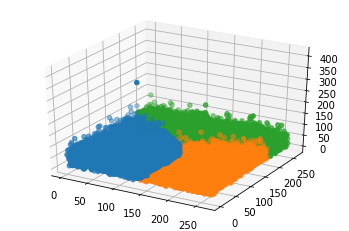

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(cluster_1_gp['PULocationID'], cluster_1_gp['DOLocationID'], 
             cluster_1_gp['base_passenger_fare'])
ax.scatter3D(cluster_2_gp['PULocationID'], cluster_2_gp['DOLocationID'], 
             cluster_2_gp['base_passenger_fare'])
ax.scatter3D(cluster_0_gp['PULocationID'], cluster_0_gp['DOLocationID'],
             cluster_0_gp['base_passenger_fare'])

通过以上图我们可以发现，这三个cluster的起落点有重合，所以现在假设重合的起落点会有价位差异。如果起落点相同，如果有乘客愿意花更多钱，这些订单可以作为Urgent

In [9]:
cluster_0_1 = cluster_0_gp.merge(cluster_1_gp, on=['PULocationID', 'DOLocationID'])
cluster_0_2 = cluster_0_gp.merge(cluster_2_gp, on=['PULocationID', 'DOLocationID'])
cluster_1_2 = cluster_1_gp.merge(cluster_2_gp, on=['PULocationID', 'DOLocationID'])
cluster_0_1.loc[np.abs(cluster_0_1['base_passenger_fare_x'] - 
                cluster_0_1['base_passenger_fare_y'] > 20)]

,PULocationID,DOLocationID,base_passenger_fare_x,base_passenger_fare_y
3,17,210,56.050000,32.440968
4,20,208,99.560000,16.909649
7,28,203,108.130000,23.599722
8,36,198,74.580000,8.286335
14,50,189,57.130000,33.824474
15,51,188,76.376667,53.515000
18,56,185,71.730000,29.801786
22,65,179,95.980000,28.999512
24,66,179,75.420000,28.598049
28,74,174,45.665000,24.352953


In [10]:
print(cluster_0.loc[(cluster_0['PULocationID'] == 28) & (cluster_0['DOLocationID'] == 203)])
print(cluster_1.loc[(cluster_1['PULocationID'] == 28) & (cluster_1['DOLocationID'] == 203)])

         PULocationID  DOLocationID  base_passenger_fare  shared_request_flag  \
5000369            28           203               108.13                    0   

         PU_hour  
5000369       20  
          PULocationID  DOLocationID  base_passenger_fare  \
48428               28           203                35.54   
123328              28           203                18.05   
229832              28           203                22.92   
237497              28           203                19.70   
287771              28           203                25.92   
...                ...           ...                  ...   
11584209            28           203                19.54   
11601794            28           203                22.14   
11616185            28           203                23.60   
11617003            28           203                23.33   
11878788            28           203                24.66   

          shared_request_flag  PU_hour  
48428                    

由上图我们可以看出，初步clustering会将起落点相同价格差别相对较大的交易分开。通过这个我们可以初步锁定一些Urgent订单。例如上面的5000369订单。
总体来看K-means的效果并不理想，他不能将那些urgent订单有效的区分到一个cluster中。因为那些urgent订单数据分布并不是呈球形，而是不规则形状。所以接下来我们将尝试DBSCAN

#### DBSCAN

##### 由于DBSCAN对内存消耗较高，我们从全部数据中抽取80000左右个数据进行分类，一共5组.

In [11]:
# weather = pd.read_csv('drive/MyDrive/nyc tlc/nyc 2021-01-01 to 2021-12-31.csv')
# weather['datetime'] = pd.to_datetime(weather['datetime'])

np.random.seed(10)
datasets = []
for i in range(5):
    data = None
    for j in range(1, 13):
        filename = 'drive/MyDrive/nyc tlc/fhvhv_tripdata_2021-'
        if j < 10:
            filename += ('0' + str(j))
        else:
            filename += str(j)
        filename += '.parquet'
        trip = pd.read_parquet(filename)
        idx = np.random.randint(0, trip.shape[0], 6667)

        if data is None:
            data = trip.iloc[idx]
        else:
            data = pd.concat([data, trip.iloc[idx]], ignore_index=True)
    
    # data = data.merge(
    # weather,
    # left_on=[data['pickup_datetime'].dt.month ,data['pickup_datetime'].dt.day],
    # right_on=[weather['datetime'].dt.month, weather['datetime'].dt.day])

    datasets.append(data)

##### 通过covariance来选择特征

In [12]:
x = datasets[0][['trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 
                 'bcf', 'sales_tax', 'congestion_surcharge', 'airport_fee', 
                 'tips', 'driver_pay']]
x.corr().style.background_gradient(cmap='coolwarm')

,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay
trip_miles,1.000000,0.772398,0.851261,0.508497,0.858757,0.646237,0.042127,0.364506,0.227886,0.878482
trip_time,0.772398,1.000000,0.790207,0.400859,0.772066,0.668606,0.123761,0.281658,0.214414,0.863663
base_passenger_fare,0.851261,0.790207,1.000000,0.483330,0.946774,0.778135,0.146818,0.330394,0.284826,0.907286
tolls,0.508497,0.400859,0.483330,1.000000,0.611091,0.118461,-0.013262,0.256531,0.179723,0.476290
bcf,0.858757,0.772066,0.946774,0.611091,1.000000,0.727763,0.127373,0.356805,0.282954,0.901246
sales_tax,0.646237,0.668606,0.778135,0.118461,0.727763,1.000000,0.232993,0.303781,0.200863,0.710551
congestion_surcharge,0.042127,0.123761,0.146818,-0.013262,0.127373,0.232993,1.000000,-0.023213,0.105766,0.130921
airport_fee,0.364506,0.281658,0.330394,0.256531,0.356805,0.303781,-0.023213,1.000000,0.160550,0.324010
tips,0.227886,0.214414,0.284826,0.179723,0.282954,0.200863,0.105766,0.160550,1.000000,0.263377
driver_pay,0.878482,0.863663,0.907286,0.476290,0.901246,0.710551,0.130921,0.324010,0.263377,1.000000


In [13]:
for i in range(5):
    data = datasets[i]
    # trip_info = data[['PULocationID', 'DOLocationID', 'base_passenger_fare', 
    #                 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 
    #                 'airport_fee', 'tips', 'shared_request_flag', 'precip', 
    #                 'windspeed', 'sealevelpressure', 'uvindex']]
    trip_info = data[['PULocationID', 'DOLocationID', 'trip_miles', 'trip_time',
                      'base_passenger_fare', 'bcf', 'sales_tax',
                      'driver_pay', 'shared_request_flag']]
    trip_info = trip_info.replace({'shared_request_flag': {'N': 0, 'Y': 1}})
    #trip_info['airport_fee'] = trip_info['airport_fee'].fillna(0)
    trip_info['base_passenger_fare'] = trip_info['base_passenger_fare'].fillna(0)
    #trip_info['PU_hour'] = pd.DatetimeIndex(data['pickup_datetime']).hour

    datasets[i] = trip_info

# print(np.cov(data[['bcf', 'base_passenger_fare']], rowvar=False))
# plt.plot(data['bcf'], data['base_passenger_fare'], 'bx')

##### 选择DBSCAN eps 参数

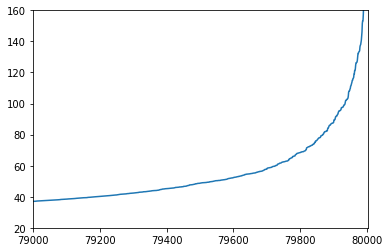

In [14]:
#calculate the average distance between each point and its n_neighbors
trip_info = datasets[0]
neighbors = NearestNeighbors(n_neighbors=18)
neighbors_fit = neighbors.fit(trip_info)
distances, indices = neighbors_fit.kneighbors(trip_info)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.xlim([79000, 80003])
plt.ylim([20, 160])
plt.plot(distances)


In [15]:
cluster_0s = None
cluster_neg1s = None
for i in range(5):

    # min_samples = 2*dim
    # eps=20 for trip_info_0_100000
    dbscan = DBSCAN(eps=145, min_samples=18, n_jobs=-1)
    dbscan.fit(datasets[i])
    dbs_label = dbscan.labels_
    #print(set(dbs_label))

    pos_0 = np.argwhere(dbs_label == 0).squeeze()
    cluster_0 = datasets[i].iloc[pos_0]
    if cluster_0s is None:
        cluster_0s = cluster_0
    else:
        cluster_0s = pd.concat([cluster_0s, cluster_0], ignore_index=True)

    #cluster_0s.append(cluster_0)

    pos_neg1 = np.argwhere(dbs_label == -1).squeeze()
    cluster_neg1 = datasets[i].iloc[pos_neg1]
    if cluster_neg1s is None:
        cluster_neg1s = cluster_neg1
    else:
        cluster_neg1s = pd.concat([cluster_neg1s, cluster_neg1], ignore_index=True)

    #cluster_neg1s.append(cluster_neg1)

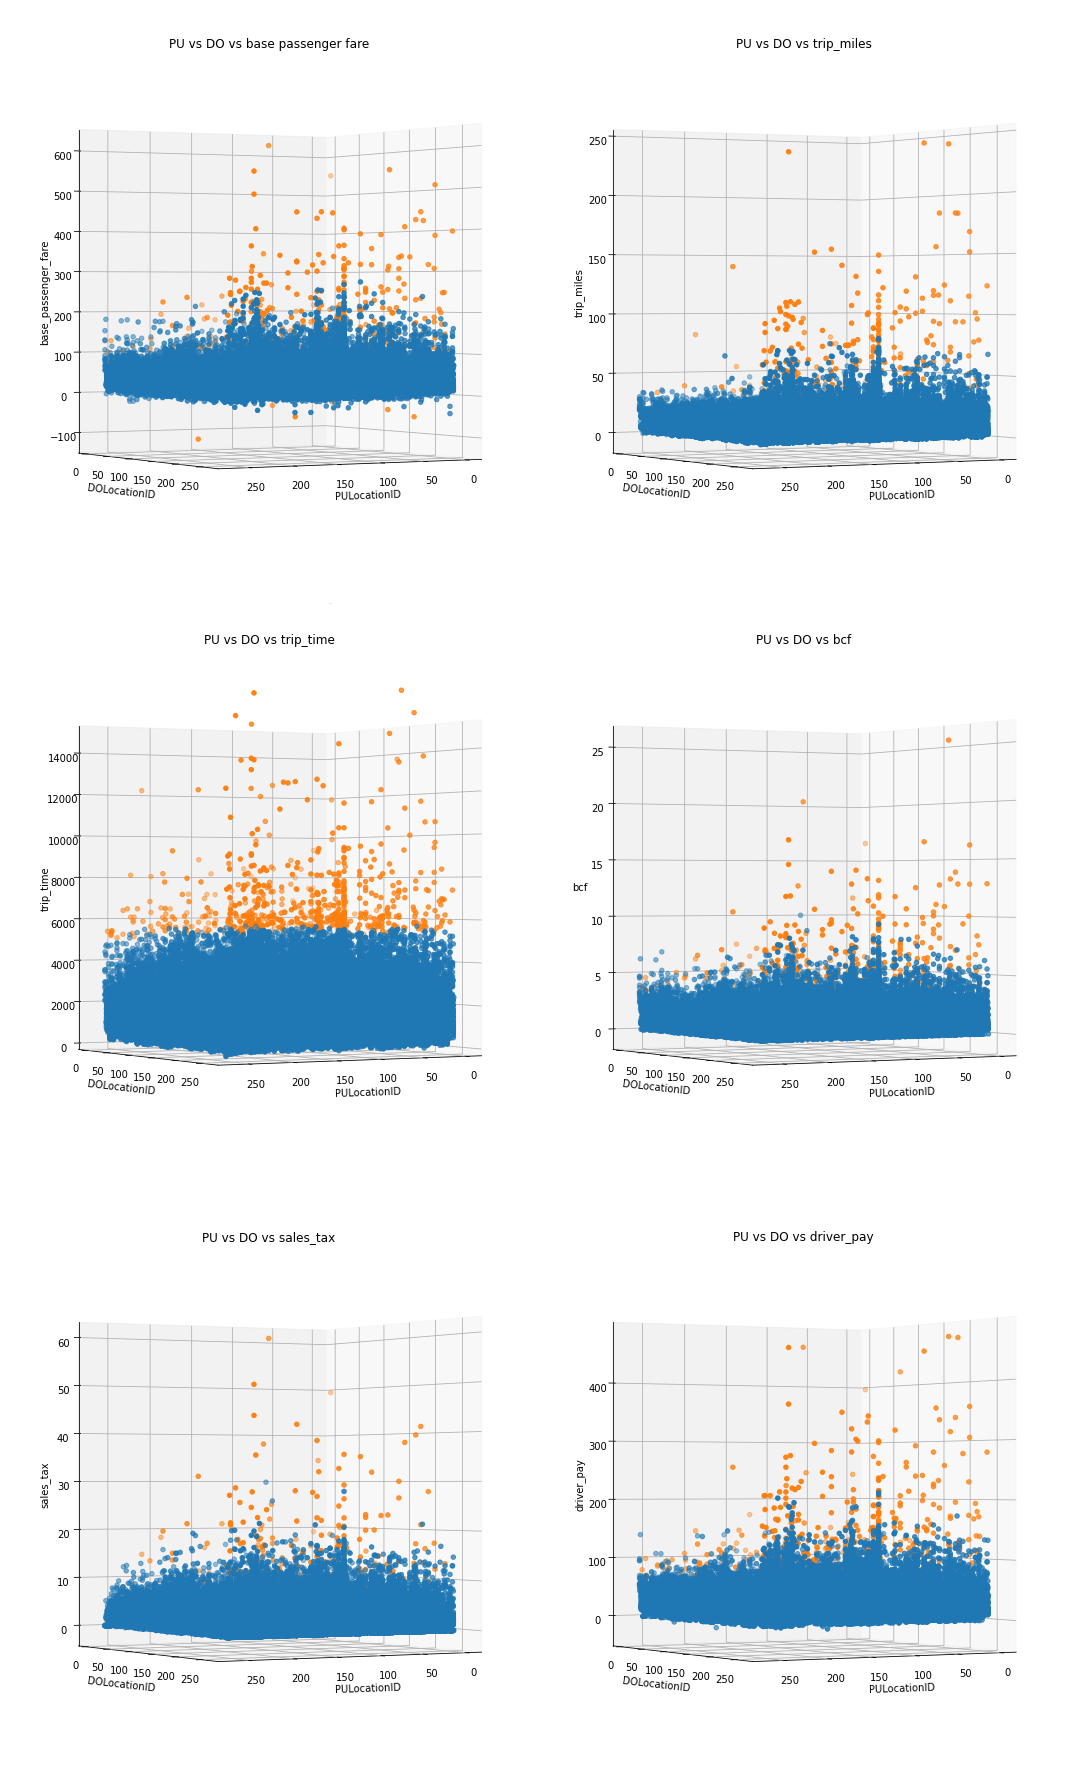

In [16]:
fig = plt.figure(figsize=(15, 25), tight_layout=True)

ax = fig.add_subplot(3, 2, 1, projection='3d')
ax.scatter3D(cluster_0s['PULocationID'], cluster_0s['DOLocationID'], 
                cluster_0s['base_passenger_fare'])
ax.scatter3D(cluster_neg1s['PULocationID'], cluster_neg1s['DOLocationID'], 
                cluster_neg1s['base_passenger_fare'])
ax.set_title('PU vs DO vs base passenger fare')
ax.set_xlabel('PULocationID')
ax.set_ylabel('DOLocationID')
ax.set_zlabel('base_passenger_fare')
ax.view_init(0, 60)

ax = fig.add_subplot(3, 2, 2, projection='3d')
ax.scatter3D(cluster_0s['PULocationID'], cluster_0s['DOLocationID'], 
                cluster_0s['trip_miles'])
ax.scatter3D(cluster_neg1s['PULocationID'], cluster_neg1s['DOLocationID'], 
                cluster_neg1s['trip_miles'])
ax.set_title('PU vs DO vs trip_miles')
ax.set_xlabel('PULocationID')
ax.set_ylabel('DOLocationID')
ax.set_zlabel('trip_miles')
ax.view_init(0, 60)

ax = fig.add_subplot(3, 2, 3, projection='3d')
ax.scatter3D(cluster_0s['PULocationID'], cluster_0s['DOLocationID'], 
                cluster_0s['trip_time'])
ax.scatter3D(cluster_neg1s['PULocationID'], cluster_neg1s['DOLocationID'], 
                cluster_neg1s['trip_time'])
ax.set_title('PU vs DO vs trip_time')
ax.axes.set_zlim3d(bottom=0, top=15000)
ax.set_xlabel('PULocationID')
ax.set_ylabel('DOLocationID')
ax.set_zlabel('trip_time')
ax.view_init(0, 60)

ax = fig.add_subplot(3, 2, 4, projection='3d')
ax.scatter3D(cluster_0s['PULocationID'], cluster_0s['DOLocationID'], 
                cluster_0s['bcf'])
ax.scatter3D(cluster_neg1s['PULocationID'], cluster_neg1s['DOLocationID'], 
                cluster_neg1s['bcf'])
ax.set_title('PU vs DO vs bcf')
ax.set_xlabel('PULocationID')
ax.set_ylabel('DOLocationID')
ax.set_zlabel('bcf')
ax.view_init(0, 60)

ax = fig.add_subplot(3, 2, 5, projection='3d')
ax.scatter3D(cluster_0s['PULocationID'], cluster_0s['DOLocationID'], 
                cluster_0s['sales_tax'])
ax.scatter3D(cluster_neg1s['PULocationID'], cluster_neg1s['DOLocationID'], 
                cluster_neg1s['sales_tax'])
ax.set_title('PU vs DO vs sales_tax')
ax.set_xlabel('PULocationID')
ax.set_ylabel('DOLocationID')
ax.set_zlabel('sales_tax')
ax.view_init(0, 60)

ax = fig.add_subplot(3, 2, 6, projection='3d')
ax.scatter3D(cluster_0s['PULocationID'], cluster_0s['DOLocationID'], 
                cluster_0s['driver_pay'])
ax.scatter3D(cluster_neg1s['PULocationID'], cluster_neg1s['DOLocationID'], 
                cluster_neg1s['driver_pay'])
ax.set_title('PU vs DO vs driver_pay')
ax.set_xlabel('PULocationID')
ax.set_ylabel('DOLocationID')
ax.set_zlabel('driver_pay')
ax.view_init(0, 60)

plt.show()

由上图我们可以看出，DBSCAN将起落点相同，但价格，距离，时间等其他相差巨大的区分为outlier（黄点），价格相似的则分在同一个Cluster（蓝点）

从中我们可以看出，outlier订单较比普通订单在起落区域相同的情况下，会有较远的距离，较长时间，较高的价格，bcf，driver pay和税。我们可以将其视为Urgent订单，并将其客户定位为高价值客户。